In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os
import math
from tensorflow.keras import layers

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

In [2]:
def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(path, file), target_size=(32, 32, 3))))
        labels.append((label))
        
    return images, labels

In [3]:
mel_train = []
mel_test = []
label_train = []
label_test = []

In [4]:
images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/train/pain', 0)
    
mel_train += images
label_train += labels

images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/train/burping', 1)
    
mel_train += images
label_train += labels

images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/train/discomfort', 2)
    
mel_train += images
label_train += labels

images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/train/hungry', 3)
    
mel_train += images
label_train += labels

images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/train/tired', 4)
    
mel_train += images
label_train += labels


In [5]:
images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/test/pain', 0)
    
mel_test += images
label_test += labels

images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/test/burping', 1)
    
mel_test += images
label_test += labels

images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/test/discomfort', 2)
    
mel_test += images
label_test += labels

images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/test/hungry', 3)
    
mel_test += images
label_test += labels

images, labels = load_images_from_path('/Users//Desktop/Datasets/spectro_aug_tt/test/tired', 4)
    
mel_test += images
label_test += labels

In [6]:
def spec_augment(spec, num_time_drop=2, num_freq_drop=2, max_time_stripes=2, max_freq_stripes=2):
    augmented_spec = spec.copy()

    # Apply time dropping
    for _ in range(num_time_drop):
        time_start = np.random.randint(0, spec.shape[0] - 1)
        time_end = np.random.randint(time_start + 1, spec.shape[0])
        augmented_spec[time_start:time_end, :] = 0

    # Apply frequency dropping
    for _ in range(num_freq_drop):
        freq_start = np.random.randint(0, spec.shape[1] - 1)
        freq_end = np.random.randint(freq_start + 1, spec.shape[1])
        augmented_spec[:, freq_start:freq_end] = 0

    # Apply time warping
    for _ in range(max_time_stripes):
        time_start = np.random.randint(0, spec.shape[0] - 1)
        time_end = np.random.randint(time_start + 1, spec.shape[0])
        time_mid = np.random.randint(time_start, time_end)
        time_mid_val = spec[time_mid, :]
        augmented_spec[time_start:time_mid, :] = augmented_spec[time_start:time_mid, :][::-1]
        augmented_spec[time_mid:time_end, :] = augmented_spec[time_mid:time_end, :][::-1]
        augmented_spec[time_start:time_end, :] = time_mid_val

    # Apply frequency warping
    for _ in range(max_freq_stripes):
        freq_start = np.random.randint(0, spec.shape[1] - 1)
        freq_end = np.random.randint(freq_start + 1, spec.shape[1])
        freq_mid = np.random.randint(freq_start, freq_end)
        freq_mid_val = spec[:, freq_mid]
        freq_mid_val = np.expand_dims(freq_mid_val, axis=1)
        freq_mid_val = np.repeat(freq_mid_val, freq_end - freq_start, axis=1)
        augmented_spec[:, freq_start:freq_end] = freq_mid_val

    augmented_spec = resize(augmented_spec, (32, 32, 3), preserve_range=True)

    return augmented_spec


In [7]:
from tensorflow.keras.utils import to_categorical

mel_train_norm = np.array(mel_train) / 255
mel_test_norm = np.array(mel_test) / 255


label_train_encoded = to_categorical(label_train)
label_test_encoded = to_categorical(label_test)

In [8]:
# Calculate the count of each class in the training set
class_counts = np.sum(label_train_encoded, axis=0)

# Find the majority class count
majority_class_count = np.max(class_counts)

# Augment the minority classes to match the majority class count using SpecAugment
for i, count in enumerate(class_counts):
    if count < majority_class_count:
        # Determine the number of SpecAugment augmentations required for the current class
        num_augmentations = int(majority_class_count - count)

        # Get the indices of the samples belonging to the current class
        class_indices = np.where(label_train_encoded[:, i] == 1)[0]

        # Randomly select samples from the current class for SpecAugment augmentation
        selected_indices = np.random.choice(class_indices, size=num_augmentations, replace=True)

        # Apply SpecAugment augmentation to the selected samples
        augmented_mel_train = []
        augmented_labels = []
        for idx in selected_indices:
            augmented_mel_spec = spec_augment(mel_train_norm[idx])
            augmented_label = label_train_encoded[idx]
            augmented_mel_train.append(augmented_mel_spec)
            augmented_labels.append(augmented_label)
        augmented_mel_train = np.array(augmented_mel_train)
        augmented_labels = np.array(augmented_labels)

        # Concatenate the augmented samples with the original training data and labels
        mel_train_norm = np.concatenate((mel_train_norm, augmented_mel_train))
        label_train_encoded = np.concatenate((label_train_encoded, augmented_labels))

In [9]:
mel_train_norm.shape

(1525, 32, 32, 3)

In [10]:
label_train_encoded.shape

(1525, 5)

In [11]:
num_classes = 5
input_shape = (32, 32, 3)

In [28]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 220

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(mel_train_norm)

In [14]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

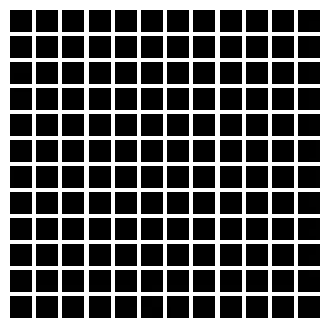

ORIGINAL


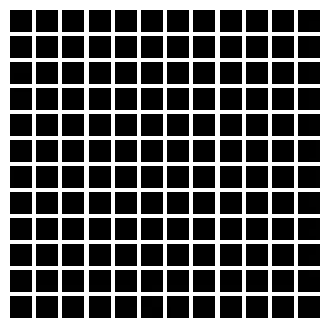

LEFT-UP


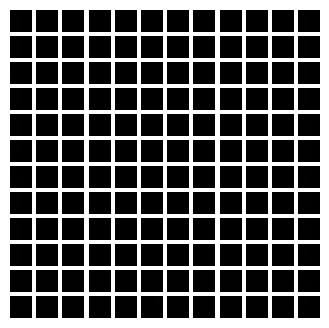

LEFT-DOWN


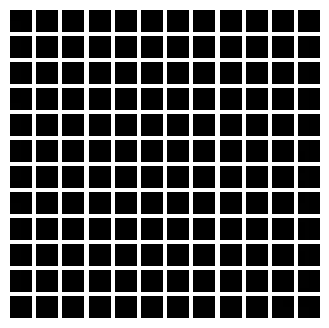

RIGHT-UP


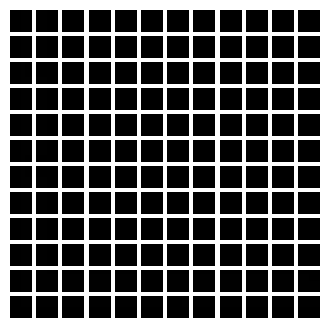

RIGHT-DOWN


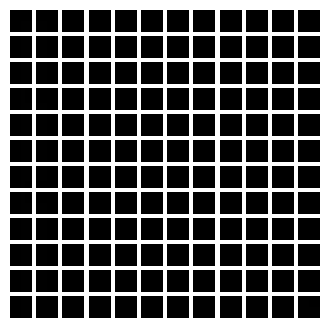

In [15]:
# Get a random image from the training dataset
# and resize the image
image = mel_train_norm[np.random.choice(range(mel_train_norm.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [17]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [19]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=(32, 32, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(5)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [20]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [29]:
def run_experiment(model, model_name):
    total_steps = int((len(mel_train_norm) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
        ],
    )
    # early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(
        x=mel_train_norm,
        y=label_train_encoded,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(mel_test_norm, label_test_encoded),
      #  callbacks=[early_stop],
    )

        # Make predictions on the test data
    y_pred = model.predict(mel_test_norm)

    # Convert the predictions from one-hot encoded format to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(label_test_encoded, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Calculate the confusion matrix
    confusion_mat = confusion_matrix(y_true_labels, y_pred_labels)

    # Calculate accuracy scores for each class
    class_accuracy = confusion_mat.diagonal() / confusion_mat.sum(axis=1)

    # Print the accuracy scores for each class
    for i, acc in enumerate(class_accuracy):
        print(f"Accuracy for class {i}: {acc}")

    _, accuracy, top_5_accuracy = model.evaluate(mel_test_norm, label_test_encoded, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    # Save the model
    model.save(f"/Users//Desktop/Datasets/T/{model_name}.h5")
    print("Model saved successfully.")
    
    return history


# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit, model_name="vanilla_vit")

# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl, model_name="modified_vit")